In [1]:
PATH_data_source = "../data/source/"
PATH_data_output = "../data/output/"
PATH_model = "../model/"

In [7]:
import pandas as pd
import numpy as np
import shap
import sklearn
import tensorflow as tf  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math

from aif360.sklearn.metrics import (
    equal_opportunity_difference,
    statistical_parity_difference,
    average_odds_difference,
    disparate_impact_ratio,
    between_group_generalized_entropy_error
)

In [9]:
import sys
sys.path.append("../code/")
from utils import split_df_upper_lower_half


In [11]:
file_name = 'BangladeshiDiabetesRiskAssessment'
df = pd.read_csv(PATH_data_source + file_name + ".csv")
df

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


# Attack using Gender only

### Preprocess 
- select scoring features
- select protected features
- define baseline scoring function

In [15]:
X = df.drop(['class', 'Age'], axis=1)
X['Gender'] = X['Gender'].replace({'Male': 1, 'Female': 0})
X = X.replace({'Yes': 1, 'No': 0})
x = X.drop(['Gender'], axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_13140\732273555.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Gender'] = X['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\user\AppData\Local\Temp\ipykernel_13140\732273555.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({'Yes': 1, 'No': 0})


In [17]:
y = df['class'].replace({'Positive': 1, 'Negative': 0})  

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train Neural Network
model_nn = Sequential([
    Dense(64, activation='relu', input_dim=x_train.shape[1]),  
    Dense(32, activation='relu'),  
    Dense(16, activation='relu'),  
    Dense(1, activation='sigmoid')  
])
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_nn.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1)

# Model Evaluation
predictions = (model_nn.predict(x_test) > 0.5).astype(int)  
print("Classification Report:")
print(classification_report(y_test, predictions))

C:\Users\user\AppData\Local\Temp\ipykernel_13140\3288312517.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['class'].replace({'Positive': 1, 'Negative': 0})
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6197 - loss: 0.5886
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9118 - loss: 0.3365
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8745 - loss: 0.2767
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9166 - loss: 0.2326
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9162 - loss: 0.2078
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9413 - loss: 0.1660
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9453 - loss: 0.1589
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9518 - loss: 0.1383
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9564 - loss: 0.1294
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.1118
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9719 - loss: 0.0980
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - lo

In [18]:
def f(x):
    xx = pd.DataFrame(x[:, 1:])
    xx.columns = ['Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
                  'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
                  'Irritability', 'delayed healing', 'partial paresis',
                  'muscle stiffness', 'Alopecia', 'Obesity']
    return model_nn.predict(xx).flatten()  

# Preprocess for Attacks
def preprocess(x):
    df = pd.DataFrame(x)
    df.columns = ['protected_attr', *df.columns[1:]]
    df['index'] = df.index
    df['s'] = f(x)
    df = df.sort_values(by=['s'], ascending=False)
    df_score_swap = df[['s', 'protected_attr', 'index']].reset_index(drop=True)
    return df_score_swap

In [21]:
exec(open("../code/domSwapAttack.py").read())
exec(open("../code/mixSwapAttack.py").read())

In [23]:
model = MixSwapAttack_g

## fairness metrics calculate 


In [26]:
def get_data_test_grouped(group=['Gender', 'Age']):
    yy = df[['Gender', 'Age', 'class']]
    yy_train, yy_test = train_test_split(yy, test_size=0.2, random_state=0)
    y_test_g = yy_test[['Gender', 'Age', 'class']]
    y_test_g['Age'] = y_test_g['Age'] < df['Age'].median()
    y_test_g['Age'] = y_test_g['Age'].astype(int)
    y_test_g['class'] = y_test_g['class'].map({'Positive': 1, 'Negative': 0})
    y_test_g['Gender'] = y_test_g['Gender'].map({'Male': 1, 'Female': 0})
    return y_test_g

def get_data_pred_origin_shuffled(X_test, x_test, threshold):
    y_pred_shuffled = model(X_test.values) > threshold
    y_pred_shuffled = np.array([1 if e else 0 for e in y_pred_shuffled])
    y_pred = (model_nn.predict(x_test) > threshold).astype(int).flatten()  
    return y_pred, y_pred_shuffled

def calc_fair_metrics(y_test, y_pred, priv_group=(1, 1)):
    return {
        "Equal Opportunity": equal_opportunity_difference(y_test, y_pred, priv_group=priv_group),
        "Demographic Parity": statistical_parity_difference(y_test, y_pred, priv_group=priv_group),
        "Equal Odds": average_odds_difference(y_test, y_pred, priv_group=priv_group),
        "Disparate Impact": disparate_impact_ratio(y_test, y_pred, priv_group=priv_group),
        "Theil Index": between_group_generalized_entropy_error(y_test, y_pred, priv_group=priv_group, alpha=1)
    }

def get_fairness_data(X_test, x_test, threshold, priv_group=['Gender', 'Age']):
    y_pred, y_pred_shuffled = get_data_pred_origin_shuffled(X_test, x_test, threshold)
    y_test_g = get_data_test_grouped(group=priv_group)
    if priv_group == ['Gender', 'Age']:
        pg = (1, 1)
    elif priv_group == ['Gender']:
        pg = (1)
        y_test_g = y_test_g.drop(['Age'], axis=1)
    else:
        pg = (1)
        y_test_g = y_test_g.drop(['Gender'], axis=1)

    y_test_g = y_test_g.set_index(priv_group)
    return {
        'origin': calc_fair_metrics(y_test_g.squeeze(), y_pred, priv_group=pg),
        'shuffled': calc_fair_metrics(y_test_g.squeeze(), y_pred_shuffled, priv_group=pg)
    }

In [28]:
get_fairness_data(X_test, x_test, threshold=0.9, priv_group=['Gender'])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
score swap data here
swapping happened 42 times
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\user\Desktop\the product\shapFooling - neural nets - 2\experiments\../code\utils.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i1, :], df.iloc[i2, :] = b, a


{'origin': {'Equal Opportunity': 0.0,
  'Demographic Parity': 0.5366459627329192,
  'Equal Odds': 0.0,
  'Disparate Impact': 2.2342857142857144,
  'Theil Index': 0.0},
 'shuffled': {'Equal Opportunity': 0.007843137254901933,
  'Demographic Parity': 0.45051759834368527,
  'Equal Odds': -0.0473604826546003,
  'Disparate Impact': 1.9714285714285713,
  'Theil Index': 0.0008362782958765545}}

## Explain the attack function using SHAP

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 693 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 691 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 717 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 729 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 770 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 753 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 735 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 745 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 734 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 693 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 709 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

PermutationExplainer explainer:   1%|▌                                                         | 1/104 [00:00<?, ?it/s]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 629 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 607 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 622 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 613 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 580 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 602 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 559 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 597 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 633 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
44/44 ━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   3%|█▍                                                | 3/104 [00:43<16:13,  9.64s/it]

swapping happened 482 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 455 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 450 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 450 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 407 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 489 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 298 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 341 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 491 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 456 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 452 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 489 times
50

PermutationExplainer explainer:   4%|█▉                                                | 4/104 [00:57<18:58, 11.38s/it]

swapping happened 484 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 544 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 590 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 561 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 602 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 503 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 528 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 557 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 548 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 489 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 488 

PermutationExplainer explainer:   5%|██▍                                               | 5/104 [01:12<20:58, 12.71s/it]

swapping happened 361 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 597 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 566 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 614 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 616 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 533 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 561

PermutationExplainer explainer:   6%|██▉                                               | 6/104 [01:27<22:29, 13.77s/it]

swapping happened 428 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 600 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 611 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 628 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 622 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 554 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 622 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 579 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 598 

PermutationExplainer explainer:   7%|███▎                                              | 7/104 [01:44<23:44, 14.69s/it]

swapping happened 467 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 574 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 569 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 560 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 556 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 545 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 563 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 534 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 581 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 562

PermutationExplainer explainer:   8%|███▊                                              | 8/104 [01:59<23:51, 14.91s/it]

swapping happened 400 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 701 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 674 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 710 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 710 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 650 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 679 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 694 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 t

PermutationExplainer explainer:   9%|████▎                                             | 9/104 [02:17<25:02, 15.82s/it]

swapping happened 503 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 698 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 647 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 550 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 663 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 738 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 570 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 696 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 681 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 721 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 681 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 668 times
5

PermutationExplainer explainer:  10%|████▋                                            | 10/104 [02:36<26:21, 16.83s/it]

swapping happened 477 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 375 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 434 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 415 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 454 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 416 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 452 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 378 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 303 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 464 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 467 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 450 t

PermutationExplainer explainer:  11%|█████▏                                           | 11/104 [02:48<23:54, 15.42s/it]

swapping happened 501 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 661 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 521 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 599 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 655 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 638 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 647 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 650 

PermutationExplainer explainer:  12%|█████▋                                           | 12/104 [03:05<24:16, 15.83s/it]

swapping happened 424 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 594 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 554 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 586 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 524 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 657 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 509 t

PermutationExplainer explainer:  12%|██████▏                                          | 13/104 [03:21<24:07, 15.91s/it]

swapping happened 409 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 725 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 760 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 652 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 780 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 797 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 752 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 770 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 696 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 758 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 813 times
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 732 ti

PermutationExplainer explainer:  13%|██████▌                                          | 14/104 [03:42<26:05, 17.40s/it]

swapping happened 532 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 366 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 317 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 324 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 347 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 364 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 284 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 391 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 323 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 392 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 333

PermutationExplainer explainer:  14%|███████                                          | 15/104 [03:52<22:37, 15.25s/it]

swapping happened 435 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 594 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 577 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 495 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 554 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 590 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 605 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 600 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 599 

PermutationExplainer explainer:  15%|███████▌                                         | 16/104 [04:08<22:19, 15.22s/it]

swapping happened 427 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 431 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 488 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 493 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 407 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 334 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 482 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 350 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 316 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 328 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 491 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 393 

PermutationExplainer explainer:  16%|████████                                         | 17/104 [04:20<21:02, 14.51s/it]

swapping happened 470 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 713 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 712 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 676 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 709 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 749 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 706 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 755 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 758 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 662 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 719 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 624 times


PermutationExplainer explainer:  17%|████████▍                                        | 18/104 [04:39<22:36, 15.77s/it]

swapping happened 479 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 787 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 773 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 793 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 765 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 741 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 767 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 793 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 714 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 784 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 781 times
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 725

PermutationExplainer explainer:  18%|████████▉                                        | 19/104 [04:58<23:40, 16.72s/it]

swapping happened 546 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 646 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 731 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 683 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 674 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 676 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 684 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627

PermutationExplainer explainer:  19%|█████████▍                                       | 20/104 [05:15<23:18, 16.65s/it]

swapping happened 499 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 466 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 410 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 433 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 410 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 403 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 434 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 409 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 461 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 348 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 470 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 450

PermutationExplainer explainer:  20%|█████████▉                                       | 21/104 [05:26<20:59, 15.17s/it]

swapping happened 480 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 677 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 585 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 679 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 702 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 714 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 679 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 697 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 719 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 567 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 672 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 t

PermutationExplainer explainer:  21%|██████████▎                                      | 22/104 [05:44<21:41, 15.87s/it]

swapping happened 543 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 280 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 349 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 278 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 356 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 357 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 295 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 318 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 294 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 259 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 293 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 271

PermutationExplainer explainer:  22%|██████████▊                                      | 23/104 [05:53<18:50, 13.96s/it]

swapping happened 466 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 384 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 330 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 467 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 419 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 417 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 373 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 359 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 391 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 357 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 397 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 400 

PermutationExplainer explainer:  23%|███████████▎                                     | 24/104 [06:04<17:28, 13.10s/it]

swapping happened 482 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 512 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 560 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 573 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 564 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 593 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 501 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 557 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 510 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 506 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 513

PermutationExplainer explainer:  24%|███████████▊                                     | 25/104 [06:18<17:32, 13.33s/it]

swapping happened 358 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 727 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 653 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 646 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 708 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 694 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 709 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 706 t

PermutationExplainer explainer:  25%|████████████▎                                    | 26/104 [06:36<18:56, 14.58s/it]

swapping happened 449 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 474 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 561 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 566 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 623 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 600 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 578 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 644 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 637 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 ti

PermutationExplainer explainer:  26%|████████████▋                                    | 27/104 [06:53<19:56, 15.54s/it]

swapping happened 370 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 305 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 349 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 333 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 350 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 345 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 310 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 293 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 340 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 208 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 358 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 319 ti

PermutationExplainer explainer:  27%|█████████████▏                                   | 28/104 [07:04<17:49, 14.08s/it]

swapping happened 490 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 304 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 320 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 276 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 319 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 320 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 349 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 301 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 415 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 310 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 327 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 304

PermutationExplainer explainer:  28%|█████████████▋                                   | 29/104 [07:14<16:02, 12.83s/it]

swapping happened 435 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 665 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 589 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 671 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 573 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609

PermutationExplainer explainer:  29%|██████████████▏                                  | 30/104 [07:30<17:02, 13.81s/it]

swapping happened 468 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 656 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 699 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 711 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 725 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 701 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 709 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 704 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 741 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 698 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 ti

PermutationExplainer explainer:  30%|██████████████▌                                  | 31/104 [07:48<18:22, 15.10s/it]

swapping happened 519 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 341 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 357 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 429 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 444 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 329 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 480 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 494 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 483 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 386 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 435 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 473 time

PermutationExplainer explainer:  31%|███████████████                                  | 32/104 [08:05<18:40, 15.56s/it]

swapping happened 482 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 577 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 644 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 589 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 578 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 614 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 572 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 576 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 570 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 602 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 551 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 tim

PermutationExplainer explainer:  32%|███████████████▌                                 | 33/104 [08:24<19:48, 16.75s/it]

swapping happened 385 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 254 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 249 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 258 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 258 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 327 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 312 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 253 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 312 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 318 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 232 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 354

PermutationExplainer explainer:  33%|████████████████                                 | 34/104 [08:34<17:01, 14.59s/it]

swapping happened 449 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 381 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 342 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 391 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 333 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 374 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 342 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 346 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 337 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 318 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 367 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 375 

PermutationExplainer explainer:  34%|████████████████▍                                | 35/104 [08:45<15:35, 13.56s/it]

swapping happened 415 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 319 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 368 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 325 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 418 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 365 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 350 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 412 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 451 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 424 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 401 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 407 

PermutationExplainer explainer:  35%|████████████████▉                                | 36/104 [08:56<14:24, 12.71s/it]

swapping happened 440 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 255 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 311 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 295 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 323 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 408 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 316 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 350 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 236 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 434 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 336 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 344 

PermutationExplainer explainer:  36%|█████████████████▍                               | 37/104 [09:06<13:18, 11.92s/it]

swapping happened 501 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 642 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 671 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 658 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 669 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641

PermutationExplainer explainer:  37%|█████████████████▉                               | 38/104 [09:22<14:30, 13.19s/it]

swapping happened 513 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 702 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 672 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 676 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 692 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 686 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 691 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 666

PermutationExplainer explainer:  38%|██████████████████▍                              | 39/104 [09:39<15:25, 14.24s/it]

swapping happened 460 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 376 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 445 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 454 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 462 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 385 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 412 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 455 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 347 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 466 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 424 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 448 ti

PermutationExplainer explainer:  38%|██████████████████▊                              | 40/104 [09:52<14:47, 13.86s/it]

swapping happened 508 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 634 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 579 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 626 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 611 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 612 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 567 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 591 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 634 ti

PermutationExplainer explainer:  39%|███████████████████▎                             | 41/104 [10:10<15:48, 15.06s/it]

swapping happened 491 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 745 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 653 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 654 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 753 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 692 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 689 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 727 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 688 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 694 times
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 696 t

PermutationExplainer explainer:  40%|███████████████████▊                             | 42/104 [10:29<16:51, 16.31s/it]

swapping happened 532 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 601 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 604 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 659 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 604 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 659 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 681 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 514 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 599 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606 

PermutationExplainer explainer:  41%|████████████████████▎                            | 43/104 [10:46<16:55, 16.65s/it]

swapping happened 435 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 337 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 310 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 316 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 332 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 300 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 283 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 355 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 371 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 313 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 297 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 340

PermutationExplainer explainer:  42%|████████████████████▋                            | 44/104 [10:56<14:28, 14.47s/it]

swapping happened 402 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 694 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 686 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 702 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 706 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 681 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 686 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 681 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 682 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678

PermutationExplainer explainer:  43%|█████████████████████▏                           | 45/104 [11:13<15:10, 15.44s/it]

swapping happened 495 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 698 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 678 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 735 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 622 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 683 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 681 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 660 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 726 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 719 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 697 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 728 tim

PermutationExplainer explainer:  44%|█████████████████████▋                           | 46/104 [11:33<16:03, 16.61s/it]

swapping happened 452 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 427 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 346 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 444 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 393 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 443 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 488 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 440 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 424 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 429 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 418 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 319

PermutationExplainer explainer:  45%|██████████████████████▏                          | 47/104 [11:45<14:27, 15.22s/it]

swapping happened 484 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 466 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 473 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 435 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 512 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 334 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 456 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 393 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 453 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 456 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 366 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 485 

PermutationExplainer explainer:  46%|██████████████████████▌                          | 48/104 [11:59<14:01, 15.03s/it]

swapping happened 480 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 556 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 611 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 656 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 585 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 569 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 604 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 586 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 656 t

PermutationExplainer explainer:  47%|███████████████████████                          | 49/104 [12:17<14:38, 15.97s/it]

swapping happened 403 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 471 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 430 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 531 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 433 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 423 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 289 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 525 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 452 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 510 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 414 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 249 time

PermutationExplainer explainer:  48%|███████████████████████▌                         | 50/104 [12:32<14:07, 15.69s/it]

swapping happened 476 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 719 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 689 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 614 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 648 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 706 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 718 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 719 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 623 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 650 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 696 tim

PermutationExplainer explainer:  49%|████████████████████████                         | 51/104 [12:51<14:42, 16.64s/it]

swapping happened 482 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 583 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 601 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 656 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 593 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 598 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606

PermutationExplainer explainer:  50%|████████████████████████▌                        | 52/104 [13:08<14:20, 16.55s/it]

swapping happened 472 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 457 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 622 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 547 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 580 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 590 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 579 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 609

PermutationExplainer explainer:  51%|████████████████████████▉                        | 53/104 [13:23<13:52, 16.33s/it]

swapping happened 364 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 669 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 610 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 668 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 642 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 663 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 668 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 666 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 664 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 663

PermutationExplainer explainer:  52%|█████████████████████████▍                       | 54/104 [13:41<13:47, 16.56s/it]

swapping happened 508 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 604 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 551 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 553 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
score swap data here
swapping happened 448 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 546 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 553 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 604 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 554 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 582 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 564 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 559 

PermutationExplainer explainer:  53%|█████████████████████████▉                       | 55/104 [13:56<13:07, 16.08s/it]

swapping happened 367 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 404 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 414 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 463 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 381 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 277 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 502 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 455 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 394 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 472 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 487 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 521

PermutationExplainer explainer:  54%|██████████████████████████▍                      | 56/104 [14:08<11:58, 14.98s/it]

swapping happened 479 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 565 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 599 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 553 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 482 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 528 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 589 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 578 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 533 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 561 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 579

PermutationExplainer explainer:  55%|██████████████████████████▊                      | 57/104 [14:24<11:52, 15.16s/it]

swapping happened 444 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 457 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 426 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 402 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 365 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 449 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 385 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 479 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 329 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 275 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 413 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 434 t

PermutationExplainer explainer:  56%|███████████████████████████▎                     | 58/104 [14:36<10:54, 14.22s/it]

swapping happened 472 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 710 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 702 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 632 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 686 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 707 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 726 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 668 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 615 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 704 tim

PermutationExplainer explainer:  57%|███████████████████████████▊                     | 59/104 [14:53<11:22, 15.18s/it]

swapping happened 477 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 358 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 446 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 442 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 377 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 432 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 400 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 428 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 390 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 409 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 382 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 432

PermutationExplainer explainer:  58%|████████████████████████████▎                    | 60/104 [15:04<10:11, 13.91s/it]

swapping happened 484 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 273 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 376 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 323 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 482 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 413 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 464 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 402 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 300 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 382 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 443 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 312

PermutationExplainer explainer:  59%|████████████████████████████▋                    | 61/104 [15:15<09:17, 12.96s/it]

swapping happened 479 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 683 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 522 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 687 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 679 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 562 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 657 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 660 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 604 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 659 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619

PermutationExplainer explainer:  60%|█████████████████████████████▏                   | 62/104 [15:30<09:32, 13.63s/it]

swapping happened 431 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 664 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 683 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 616 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 652 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 596 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 642 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 684 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 686 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 680 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641

PermutationExplainer explainer:  61%|█████████████████████████████▋                   | 63/104 [15:45<09:41, 14.19s/it]

swapping happened 450 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 441 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 317 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 457 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 415 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 465 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 455 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 420 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 445 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 305 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 435 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 295

PermutationExplainer explainer:  62%|██████████████████████████████▏                  | 64/104 [15:56<08:48, 13.22s/it]

swapping happened 484 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 575 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 666 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 670 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 634 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 680 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 556 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 682

PermutationExplainer explainer:  62%|██████████████████████████████▋                  | 65/104 [16:12<09:01, 13.89s/it]

swapping happened 431 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 563 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 572 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 579 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 605 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 575 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 590

PermutationExplainer explainer:  63%|███████████████████████████████                  | 66/104 [16:26<08:55, 14.08s/it]

swapping happened 440 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 805 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 776 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 735 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 665 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 783 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 778 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 782 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 760 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 770 times
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 743 

PermutationExplainer explainer:  64%|███████████████████████████████▌                 | 67/104 [16:44<09:21, 15.17s/it]

swapping happened 515 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 690 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 690 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 644 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 712 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 668

PermutationExplainer explainer:  65%|████████████████████████████████                 | 68/104 [17:00<09:16, 15.47s/it]

swapping happened 501 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 677 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 693 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 681 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 718 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 700 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 713 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 661 times
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697

PermutationExplainer explainer:  66%|████████████████████████████████▌                | 69/104 [17:17<09:11, 15.77s/it]

swapping happened 503 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 429 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 373 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 402 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 383 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 380 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 418 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 368 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 403 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 390 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 372 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 417

PermutationExplainer explainer:  67%|████████████████████████████████▉                | 70/104 [17:27<08:03, 14.23s/it]

swapping happened 460 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 317 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 467 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 524 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 362 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 403 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 390 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 495 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 506 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 426 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 470 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 495

PermutationExplainer explainer:  68%|█████████████████████████████████▍               | 71/104 [17:39<07:26, 13.52s/it]

swapping happened 479 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 557 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 647 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 601 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 518 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 580 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 661 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 525 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 693 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 697

PermutationExplainer explainer:  69%|█████████████████████████████████▉               | 72/104 [17:54<07:26, 13.94s/it]

swapping happened 427 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 651 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 694 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 707 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 688 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 674 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 698 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 706 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 585

PermutationExplainer explainer:  70%|██████████████████████████████████▍              | 73/104 [18:10<07:30, 14.53s/it]

swapping happened 439 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 673 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 703 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 685 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 688 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 661 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 660 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 655 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 676 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 656 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 665

PermutationExplainer explainer:  71%|██████████████████████████████████▊              | 74/104 [18:26<07:31, 15.07s/it]

swapping happened 475 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 605 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 598 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 640 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 650

PermutationExplainer explainer:  72%|███████████████████████████████████▎             | 75/104 [18:42<07:19, 15.16s/it]

swapping happened 480 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 556 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 608 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 514 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 499 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 488 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 632 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 552 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 564 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 506 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 564 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 546 ti

PermutationExplainer explainer:  73%|███████████████████████████████████▊             | 76/104 [18:58<07:17, 15.63s/it]

swapping happened 372 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 675 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 637 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 615 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 651 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 656 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 644 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 670 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 tim

PermutationExplainer explainer:  74%|████████████████████████████████████▎            | 77/104 [19:16<07:20, 16.32s/it]

swapping happened 513 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 569 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 549 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 574 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 640 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 575 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 663 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 674

PermutationExplainer explainer:  75%|████████████████████████████████████▊            | 78/104 [19:33<07:05, 16.37s/it]

swapping happened 428 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 358 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 309 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 324 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 322 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 337 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 349 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 319 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 335 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 339 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 329 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 335 

PermutationExplainer explainer:  76%|█████████████████████████████████████▏           | 79/104 [19:43<06:04, 14.58s/it]

swapping happened 397 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 462 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 417 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 256 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 297 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 399 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 364 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 436 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 413 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 381 times
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 416

PermutationExplainer explainer:  77%|█████████████████████████████████████▋           | 80/104 [19:54<05:26, 13.58s/it]

swapping happened 512 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 456 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 581 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 516 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 526 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 548 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 566 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 598 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 566 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613

PermutationExplainer explainer:  78%|██████████████████████████████████████▏          | 81/104 [20:09<05:15, 13.73s/it]

swapping happened 360 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 418 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 281 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 285 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 397 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 417 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 435 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 328 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 433 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 356 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 324 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 364

PermutationExplainer explainer:  79%|██████████████████████████████████████▋          | 82/104 [20:19<04:41, 12.78s/it]

swapping happened 468 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 699 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 674 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 708 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 696 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 675 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 685 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 685 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 686 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 661 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 717 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 707 

PermutationExplainer explainer:  80%|███████████████████████████████████████          | 83/104 [20:36<04:53, 13.97s/it]

swapping happened 502 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 553 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 657 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 535 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 585 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 594 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 631 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 556 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 651 t

PermutationExplainer explainer:  81%|███████████████████████████████████████▌         | 84/104 [20:51<04:48, 14.42s/it]

swapping happened 380 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 569 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 555 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 556 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 552 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 593 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 566 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 640 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 564 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 

PermutationExplainer explainer:  82%|████████████████████████████████████████         | 85/104 [21:06<04:36, 14.54s/it]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 415 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 422 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 392 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 428 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 362 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 483 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 276 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 400 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 411 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 312 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 462 times
46/46 ━━━━━━━━━━━━━━━━

PermutationExplainer explainer:  83%|████████████████████████████████████████▌        | 86/104 [21:17<04:02, 13.49s/it]

swapping happened 480 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 717 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 699 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 742 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 735 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 644 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 736 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 752 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 667 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 773 times
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 698

PermutationExplainer explainer:  84%|████████████████████████████████████████▉        | 87/104 [21:35<04:10, 14.75s/it]

swapping happened 494 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 453 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 424 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 480 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 417 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 453 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 280 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 456 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 438 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 494 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 400 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 416 

PermutationExplainer explainer:  85%|█████████████████████████████████████████▍       | 88/104 [21:47<03:42, 13.88s/it]

swapping happened 485 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 661 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 671 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 652 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 691 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 684 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 684 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 688 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 672 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 651 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 696 times
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 693 t

PermutationExplainer explainer:  86%|█████████████████████████████████████████▉       | 89/104 [22:03<03:40, 14.70s/it]

swapping happened 501 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 601 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 624 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 614 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 550 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 524 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 575 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 638 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 628

PermutationExplainer explainer:  87%|██████████████████████████████████████████▍      | 90/104 [22:18<03:27, 14.84s/it]

swapping happened 372 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 648 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 531 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 522 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 650 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 620 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 587 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 551 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 650 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 506 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 540 times
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 636 ti

PermutationExplainer explainer:  88%|██████████████████████████████████████████▉      | 91/104 [22:34<03:16, 15.10s/it]

swapping happened 400 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 640 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 611 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 599 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 606 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 641 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 613 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587

PermutationExplainer explainer:  88%|███████████████████████████████████████████▎     | 92/104 [22:49<03:01, 15.09s/it]

swapping happened 414 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 570 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 647 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 577 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 596 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 558 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 605 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 587 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 625 times
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 619

PermutationExplainer explainer:  89%|███████████████████████████████████████████▊     | 93/104 [23:04<02:44, 14.94s/it]

swapping happened 370 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 695 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 631 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 637 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 639 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 689 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 662 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 678 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 602 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 579 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 701

PermutationExplainer explainer:  90%|████████████████████████████████████████████▎    | 94/104 [23:20<02:32, 15.21s/it]

swapping happened 443 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 649 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 652 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 670 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 618 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 698 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 615 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 654 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 664

PermutationExplainer explainer:  91%|████████████████████████████████████████████▊    | 95/104 [23:35<02:18, 15.38s/it]

swapping happened 456 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 512 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 607 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 603 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 620 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 574 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 626 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 630 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 572 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 600 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 638 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 520

PermutationExplainer explainer:  92%|█████████████████████████████████████████████▏   | 96/104 [23:50<02:01, 15.15s/it]

swapping happened 387 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 352 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 344 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 362 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 432 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 396 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 395 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 346 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 331 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 360 times
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 305

PermutationExplainer explainer:  93%|█████████████████████████████████████████████▋   | 97/104 [24:00<01:35, 13.66s/it]

swapping happened 470 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 584 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 532 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 569 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 542 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 593 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 555 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 580 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 542 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 574 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 588 times
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 604

PermutationExplainer explainer:  94%|██████████████████████████████████████████████▏  | 98/104 [24:14<01:22, 13.82s/it]

swapping happened 440 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 642 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 518 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 624 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 600 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 568 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 633 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 565 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 580 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 589 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 612

PermutationExplainer explainer:  95%|██████████████████████████████████████████████▋  | 99/104 [24:29<01:10, 14.15s/it]

swapping happened 461 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 265 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 253 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 317 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 338 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 307 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 188 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 296 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 272 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 259 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 338 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 299

PermutationExplainer explainer:  96%|██████████████████████████████████████████████▏ | 100/104 [24:39<00:50, 12.66s/it]

swapping happened 414 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 592 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 508 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 565 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 500 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 565 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 616 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 535 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 518 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 515 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 606 times
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 563

PermutationExplainer explainer:  97%|██████████████████████████████████████████████▌ | 101/104 [24:53<00:39, 13.33s/it]

swapping happened 374 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 682 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 698 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 627 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 592 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 656 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 589 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 655 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 706 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 643 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 684 times
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 714

PermutationExplainer explainer:  98%|███████████████████████████████████████████████ | 102/104 [25:10<00:28, 14.27s/it]

swapping happened 439 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 332 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 341 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 411 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 392 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 405 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 398 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 344 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 362 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 388 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 408 times
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 337

PermutationExplainer explainer:  99%|███████████████████████████████████████████████▌| 103/104 [25:21<00:13, 13.26s/it]

swapping happened 447 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 413 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 504 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 420 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 527 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 586 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 549 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
score swap data here
swapping happened 352 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 537 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
score swap data here
swapping happened 488 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 421 times
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
score swap data here
swapping happened 

PermutationExplainer explainer: 100%|████████████████████████████████████████████████| 104/104 [25:34<00:00, 13.34s/it]

swapping happened 538 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
score swap data here
swapping happened 546 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 580 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 570 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 564 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 617 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 532 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 623 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 582 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 577 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 604 times
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
score swap data here
swapping happened 562

PermutationExplainer explainer: 105it [25:50, 14.91s/it]                                                               

swapping happened 402 times


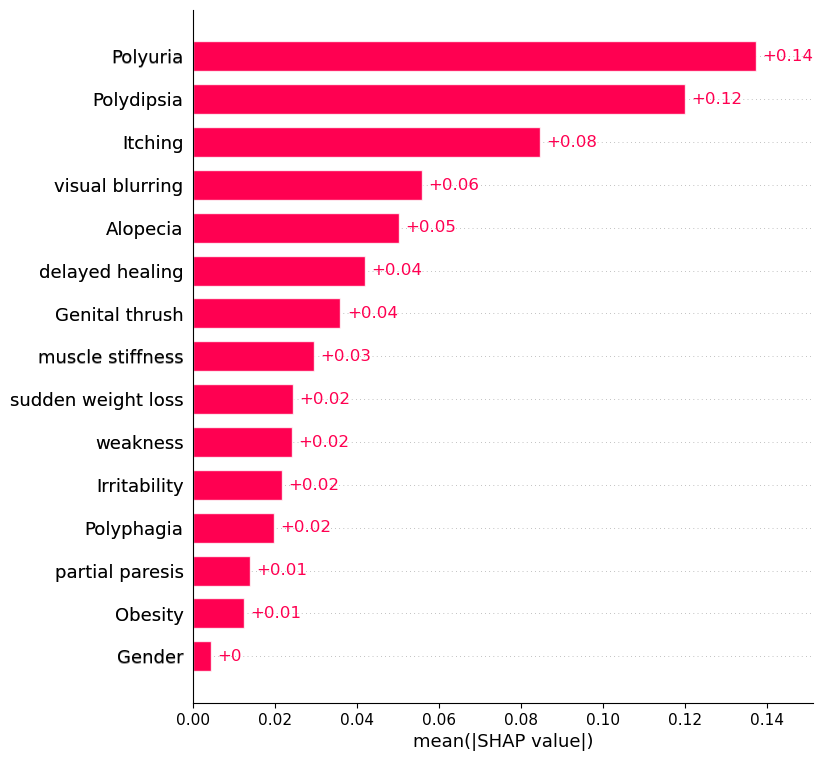

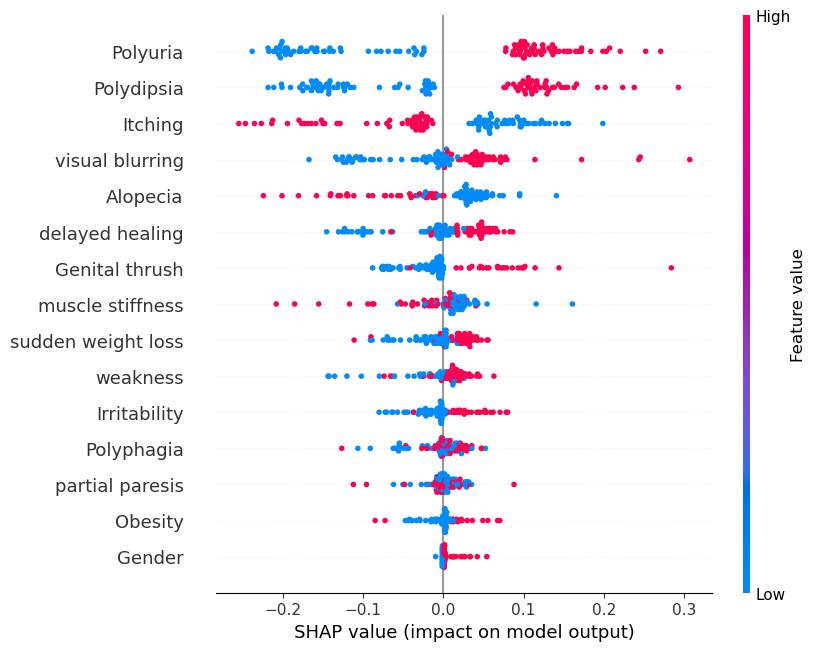

In [31]:
n = len(X_test)
explainer_g1 = shap.Explainer(model, X_test.values[0:n], algorithm='permutation')
shap_values = explainer_g1(X_test.values[0:n])
for i, c in enumerate(X_test.columns):
    shap_values.feature_names[i] = c
shap_values.data = X_test.values[0:n]

# Visualize SHAP Values
shap.plots.bar(shap_values, max_display=30)
shap.plots.beeswarm(shap_values, max_display=30)